In [1]:
# Importing Libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations  #Permutation and Combination in Python

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score

In [2]:
# Getting our data

data = pd.read_csv('heart.csv')

In [3]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [4]:
# Renaming the columns for better understanding of features 

data.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'serum_cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate',
       'exercise_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [5]:
data.head()

,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [6]:
# Lets see how our features correlate with the target variable 
#corr() function to find the correlation among the columns in the dataframe
x = data.corr()
pd.DataFrame(x['target']).sort_values(by='target',ascending = False).style.background_gradient(cmap = 'copper')

,target
target,1.000000
chest_pain_type,0.433798
max_heart_rate,0.421741
st_slope,0.345877
rest_ecg,0.137230
fasting_blood_sugar,-0.028046
serum_cholesterol,-0.085239
resting_blood_pressure,-0.144931
age,-0.225439
sex,-0.280937


**As we saw in EDA that chest_pain_type and max_heart_rate have decent positive correlation with our target. Now these numbers say the same thing!** 

# Preprocessing

In [7]:
# NOTE: This step is not necessary, I am performing it to avoid renaming of columns after One Hot Encoding. Also,
# here we will leave two class variables as they are already one hot encoded

# Let's map these class values to something meaningful information given in dataset description


data.chest_pain_type = data.chest_pain_type.map({1:'angina pectoris', 2:'atypical angina', 3:'non-anginal pain', 4:'SMI', 0:'absent'})

data.st_slope = data.st_slope.map({1:'upsloping', 2:'horizontal', 3:'downsloping', 0:'absent'})

data.thalassemia = data.thalassemia.map({1:'normal', 2:'fixed defect', 3:'reversable defect', 0:'absent'})

In [6]:
data.head()

,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,non-anginal pain,145,233,1,0,150,0,2.3,absent,0,normal,1
1,37,1,atypical angina,130,250,0,1,187,0,3.5,absent,0,fixed defect,1
2,41,0,angina pectoris,130,204,0,0,172,0,1.4,horizontal,0,fixed defect,1
3,56,1,angina pectoris,120,236,0,1,178,0,0.8,horizontal,0,fixed defect,1
4,57,0,absent,120,354,0,1,163,1,0.6,horizontal,0,fixed defect,1


In [8]:
# Seperating out predictors(X) and target(Y)

X = data.iloc[:, 0:13] #all rows and 0 to 12 columns of data frame

Y = data.iloc[:, -1] #last column of data frame

In [9]:
X.head()

,age,sex,chest_pain_type,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_angina,st_depression,st_slope,num_major_vessels,thalassemia
0,63,1,non-anginal pain,145,233,1,0,150,0,2.3,absent,0,normal
1,37,1,atypical angina,130,250,0,1,187,0,3.5,absent,0,fixed defect
2,41,0,angina pectoris,130,204,0,0,172,0,1.4,horizontal,0,fixed defect
3,56,1,angina pectoris,120,236,0,1,178,0,0.8,horizontal,0,fixed defect
4,57,0,absent,120,354,0,1,163,1,0.6,horizontal,0,fixed defect


In [10]:
# Encoding the categorical variables using get_dummies() 
categorical_columns = ['chest_pain_type', 'thalassemia', 'st_slope']

for column in categorical_columns:
    dummies = pd.get_dummies(X[column], drop_first = True)
    X[dummies.columns] = dummies
    X.drop(column, axis =1, inplace = True)

**Note that I have passed drop_first as True in get_dummies function to avoid dummy variable trap. It is not very necessary in models where you apply L1 or L2 regularization as it will balance any collinearity caused by dummy columns.**


In [11]:
X.head()

,age,sex,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_angina,st_depression,num_major_vessels,angina pectoris,atypical angina,non-anginal pain,fixed defect,normal,reversable defect,horizontal,upsloping
0,63,1,145,233,1,0,150,0,2.3,0,0,0,1,0,1,0,0,0
1,37,1,130,250,0,1,187,0,3.5,0,0,1,0,1,0,0,0,0
2,41,0,130,204,0,0,172,0,1.4,0,1,0,0,1,0,0,1,0
3,56,1,120,236,0,1,178,0,0.8,0,1,0,0,1,0,0,1,0
4,57,0,120,354,0,1,163,1,0.6,0,0,0,0,1,0,0,1,0


In [12]:
# Let us again look at the correlation against our target variable

temp = X.copy()
temp['target'] = Y

d = temp.corr()
pd.DataFrame(d['target']).sort_values(by='target',ascending = False).style.background_gradient(cmap = 'copper')

,target
target,1.000000
fixed defect,0.527334
max_heart_rate,0.421741
horizontal,0.394066
atypical angina,0.316742
angina pectoris,0.245879
rest_ecg,0.137230
non-anginal pain,0.086957
fasting_blood_sugar,-0.028046
serum_cholesterol,-0.085239


### **We have far better correlations after Scaling and One hot encoding.**

In [13]:
# Splitting the data into test and train 

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

print("X-Train:",X_train.shape)
print("X-Test:",X_test.shape)
print("Y-Train:",y_train.shape)
print("Y-Test:",y_test.shape)

X-Train: (242, 18)
X-Test: (61, 18)
Y-Train: (242,)
Y-Test: (61,)


In [14]:
# Scaling the continous data

num_columns =  ['resting_blood_pressure','serum_cholesterol', 'age', 'max_heart_rate', 'st_depression']

scaler = StandardScaler()

scaler.fit(X_train[num_columns])

X_train[num_columns] = scaler.transform(X_train[num_columns])

X_test[num_columns] = scaler.transform(X_test[num_columns])

In [15]:
X_train.head()

,age,sex,resting_blood_pressure,serum_cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_angina,st_depression,num_major_vessels,angina pectoris,atypical angina,non-anginal pain,fixed defect,normal,reversable defect,horizontal,upsloping
132,-1.356798,1,-0.616856,0.914034,0,1,0.532781,0,-0.920864,0,1,0,0,1,0,0,1,0
202,0.385086,1,1.169491,0.439527,0,0,-1.753582,1,-0.193787,0,0,0,0,0,0,1,1,0
196,-0.921327,1,1.169491,-0.300704,0,1,-0.139679,0,2.350982,0,0,1,0,1,0,0,0,1
75,0.058483,0,0.276318,0.059921,0,0,0.487950,0,0.351521,0,1,0,0,1,0,0,0,1
176,0.602822,1,-0.795490,-0.319684,1,1,0.443119,1,0.351521,2,0,0,0,0,0,1,1,0


# Modelling

### Logistic Regression

In [28]:
# Creating a function to plot correlation matrix and roc_auc_curve

def show_metrics(model):
    fig = plt.figure(figsize=(25, 10))

    # Confusion matrix
    fig.add_subplot(121)
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, annot_kws={"size": 16}, fmt='g')

    # ROC Curve
    fig.add_subplot(122)
    
    
    auc_roc = roc_auc_score(y_test, model.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

    plt.plot(fpr, tpr, color='darkorange', lw=2, marker='o', label='Trained Model (area = {0:0.3f})'.format(auc_roc))
    plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--', label= 'No Skill (area = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [29]:
# creating our model instance
log_reg = LogisticRegression()

# fitting the model
log_reg.fit(X_train, y_train)

# predicting the target vectors
y_pred=log_reg.predict(X_test)

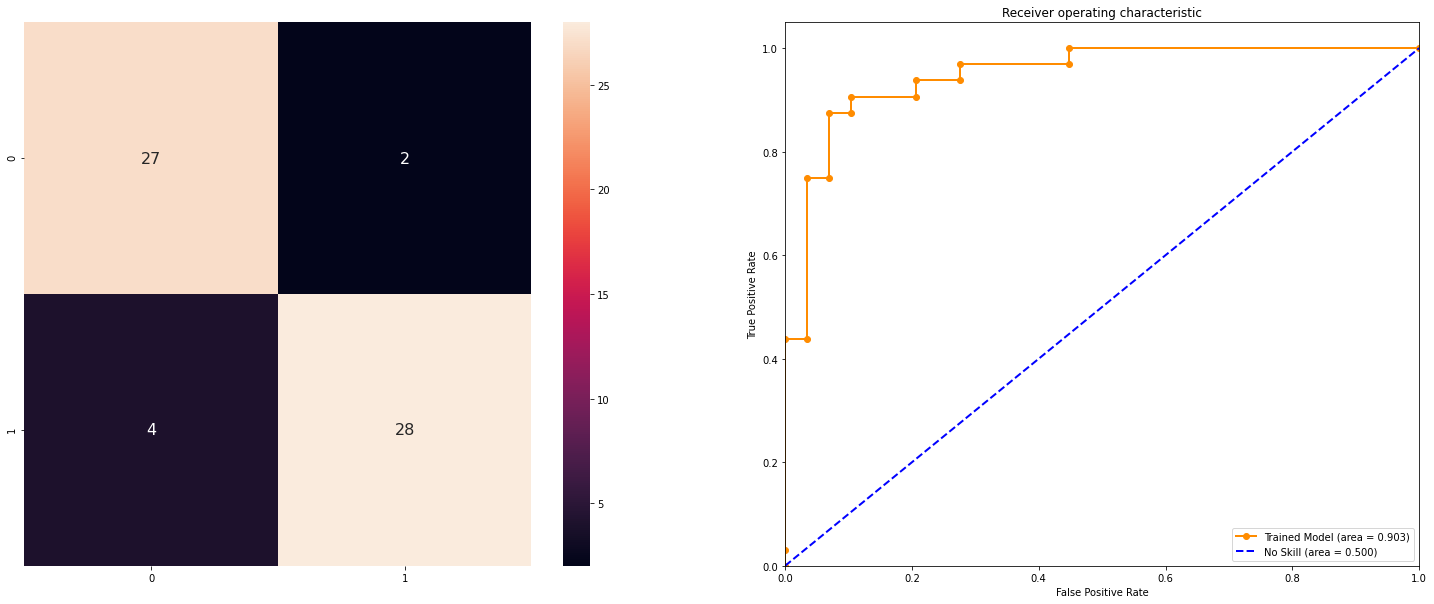

In [30]:
# calling our show_metrics function

show_metrics(log_reg)

In [31]:
# let's look at our accuracy

accuracy = accuracy_score(y_pred, y_test)

print(f"The accuracy on test set using Logistic Regression is: {np.round(accuracy, 3)*100.0}%")

The accuracy on test set using Logistic Regression is: 90.2%


**Woah, 90% on the first try!**

**Logistic Regression seems to work very well as it is easily able to draw hyperplane and the reason for that can be - Patients with higher ages usually have the problem of high_blood_pressure thus which make it easy to seperate it from the low age patients. (This Speculation might be wrong!)**

In [32]:
# Getting precision, recall and f1-score via classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        29
           1       0.93      0.88      0.90        32

    accuracy                           0.90        61
   macro avg       0.90      0.90      0.90        61
weighted avg       0.90      0.90      0.90        61



### KNearestNeighbors

In [33]:
from sklearn.neighbors import KNeighborsClassifier

# creating a list of K's for performing KNN
my_list = list(range(0,30))

# filtering out only the odd K values
neighbors = list(filter(lambda x: x % 2 != 0, my_list))

# list to hold the cv scores
cv_scores = []

# perform 10-fold cross validation with default weights
for k in neighbors:
  Knn = KNeighborsClassifier(n_neighbors = k, algorithm = 'brute')
  scores = cross_val_score(Knn, X_train, y_train, cv=10, scoring='accuracy', n_jobs = -1)
  cv_scores.append(scores.mean())

# finding the optimal k
optimal_k = neighbors[cv_scores.index(max(cv_scores))]
print("The optimal K value is with default weight parameter: ", optimal_k)

The optimal K value is with default weight parameter:  27


**We got our optimal value of K as 27 so now let's look at how our accuracy varied across all K's we tried during KFoldCV. This is sometimes important because if our Hyperparameter is giving same accuracy for a wide range of values so it is better to do early stopping and use the lower value which will avoid Underfitting or Overfitting.** 

**In our case, KNN would underfit for large values of K**

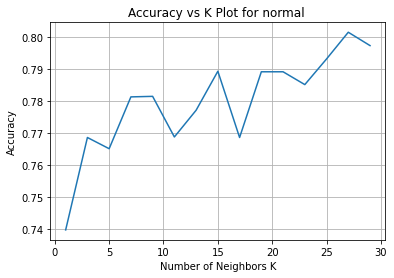

Accuracy scores for each K value is :  [0.74  0.769 0.765 0.781 0.782 0.769 0.777 0.789 0.769 0.789 0.789 0.785
 0.793 0.802 0.797]


In [34]:
# plotting accuracy vs K
plt.plot(neighbors, cv_scores)
plt.xlabel("Number of Neighbors K")
plt.ylabel("Accuracy")
plt.title("Accuracy vs K Plot for normal ")
plt.grid()
plt.show()

print("Accuracy scores for each K value is : ", np.round(cv_scores, 3))

**Looks like we got our best K. Now, lets fit our training data using this K and find out the accuracy on test.**

In [35]:
# Finding the accuracy of KNN with optimal K

from sklearn.metrics import accuracy_score

# create instance of classifier
knn_optimal = KNeighborsClassifier(n_neighbors = optimal_k, algorithm = 'kd_tree', 
                                   n_jobs = -1)

# fit the model
knn_optimal.fit(X_train, y_train)

# predict on test vector
y_pred = knn_optimal.predict(X_test)

# evaluate accuracy score
accuracy = accuracy_score(y_test, y_pred)*100
print(f"The accuracy on test set using KNN for optimal K = {optimal_k} is {np.round(accuracy, 3)}%")

The accuracy on test set using KNN for optimal K = 27 is 85.246%


### **~85 is not very good but isn't bad either!**

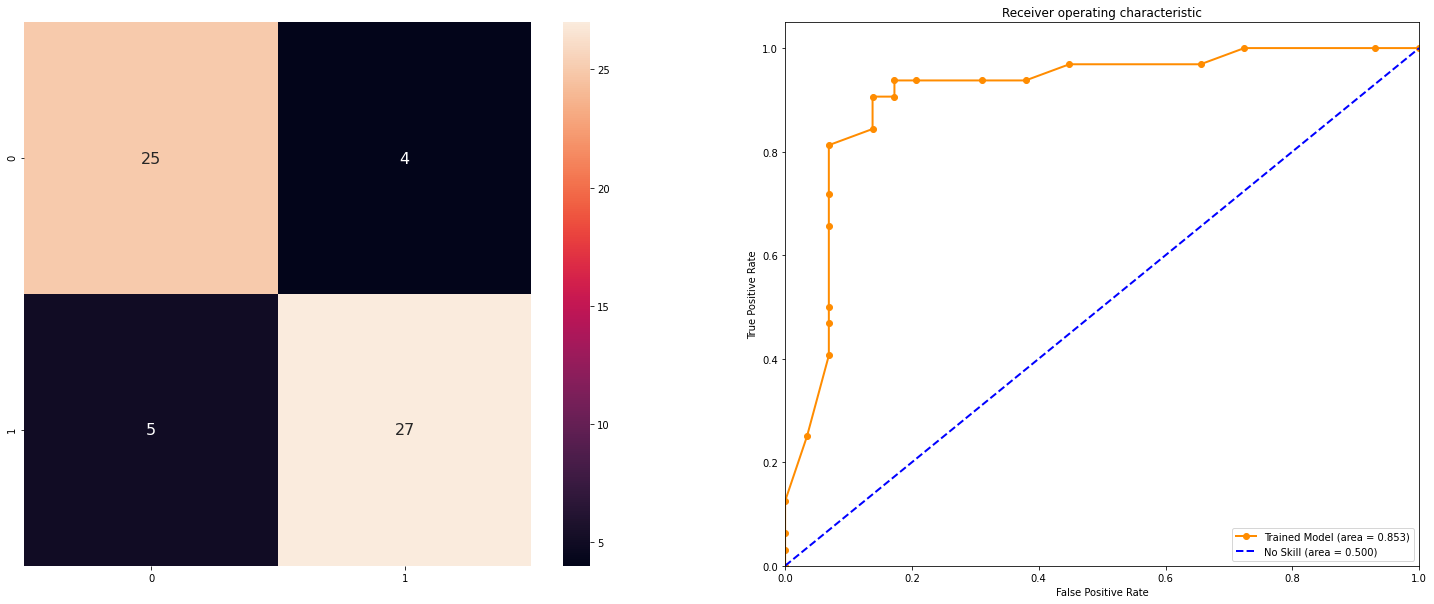

In [36]:
# calling our show_metrics function

show_metrics(knn_optimal)

## Support Vector Machine

In [37]:
# Creating an instance of the classifier
svm = SVC()

# training on train data
svm.fit(X_train, y_train)

# predicting on test data
y_pred = svm.predict(X_test)

# let's look at our accuracy
accuracy = accuracy_score(y_pred, y_test)

print(f"The accuracy on test set using SVC is: {np.round(accuracy, 3)*100.0}%")

The accuracy on test set using SVC is: 88.5%


**SVM did a good job predicting the labels, scoring ~89%**

### Ensemble Models - Random Forest Classifier

**Trees are very easy to overfit so we will first do a RandomSearchCV to find the best parameters.**

In [38]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [39]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

For me personally, I set random_state to a specific number (usually 42) so if I see variation in my programs accuracy I know it was not caused by how the data was split.

However, this can lead to my network over fitting on that specific split. So I tune my network so it works well with that split, but not necessarily on a different split.

In [40]:
# Lets look at the best parameters

rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': True}

In [41]:
# Creating an instance for the classifier
rf_best = RandomForestClassifier(**rf_random.best_params_)

# fitting the model
rf_best.fit(X_train, y_train)

# predict the labels
y_pred = rf_best.predict(X_test)

In [42]:
accuracy = accuracy_score(y_pred, y_test)

print(f"The accuracy on test set using RandomForest is: {np.round(accuracy, 3)*100.0}%")

The accuracy on test set using RandomForest is: 82.0%


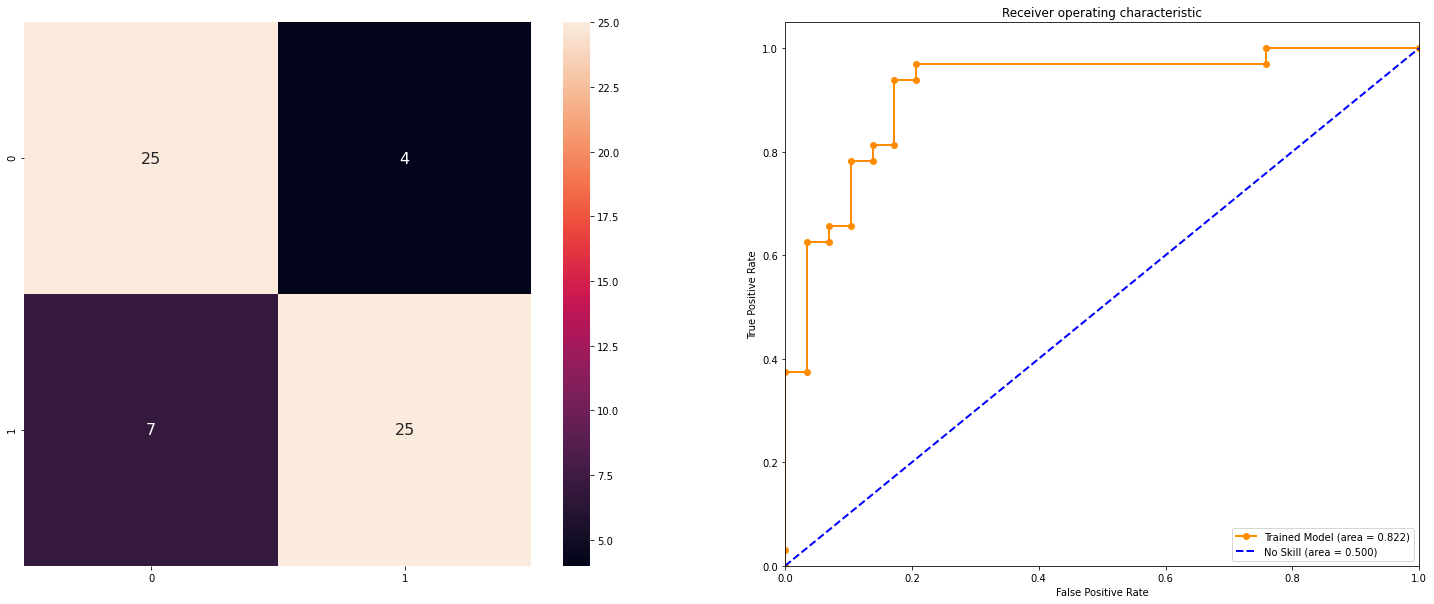

In [43]:
# calling our show_metrics function

show_metrics(rf_best)

### Ensemble Models - Voting Classifier

**It is always good to use esemble models beacuse they are very effective. Here, I will be using Voting Classifier which does exaclty what it sounds like. It takes mulitple models and combine them together and do voting on the prediction and picks the best for us.**

**Let's combine all the models together!**

In [44]:
# creating a list of our models
ensembles = [log_reg, knn_optimal, rf_best, svm]

# Train each of the model
for estimator in ensembles:
    print("Training the", estimator)
    estimator.fit(X_train,y_train)

Training the LogisticRegression()
Training the KNeighborsClassifier(algorithm='kd_tree', n_jobs=-1, n_neighbors=27)
Training the RandomForestClassifier(max_depth=40, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=2000)
Training the SVC()


In [45]:
# Find the scores of each estimator
scores = [estimator.score(X_test, y_test) for estimator in ensembles]

scores

[0.9016393442622951,
 0.8524590163934426,
 0.8524590163934426,
 0.8852459016393442]

In [46]:
# Lets define our estimators in a list

named_estimators = [
    ("log_reg",log_reg),
    ('random_forest', rf_best),
    ('svm',svm),
    ('knn', knn_optimal),
]

In [47]:
# Creating an instance for our Voting classifier

voting_clf = VotingClassifier(named_estimators)

In [48]:
# Fit the classifier

voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('log_reg', LogisticRegression()),
                             ('random_forest',
                              RandomForestClassifier(max_depth=40,
                                                     min_samples_leaf=2,
                                                     min_samples_split=10,
                                                     n_estimators=2000)),
                             ('svm', SVC()),
                             ('knn',
                              KNeighborsClassifier(algorithm='kd_tree',
                                                   n_jobs=-1,
                                                   n_neighbors=27))])

In [51]:
# Let's look at our accuracy
acc = voting_clf.score(X_test,y_test)

print(f"The accuracy on test set using voting classifier is {np.round(acc, 3)*100}%")

The accuracy on test set using voting classifier is 90.2%


**No, Improvement at all!**

**Lets generate all permutations of the names_estimators list of length 3 and then check if the do any better.**

In [52]:
# to generate permutations of length three
perm = permutations(named_estimators, 3) 

# to store the acc and classifiers
best_perm = []

# to store best classifier
best=[]

# Traverse through the obtained permutations
for i in list(perm):
    
    # fit the classifier
    voting_clf = VotingClassifier(i)
    voting_clf.fit(X_train,y_train)
    
    # obtain accracy score and append it to the list
    acc = voting_clf.score(X_test,y_test)
    best_perm.append([acc,voting_clf])
    

# find out the maximum accuracy
maximum = max(best_perm, key = lambda x:x[0])
              
# there can be multiple permutations for which we get 
# best score so find all of them and append to best
for i in range(len(best_perm)):
    if maximum[0]==best_perm[i][0]:
        best.append(best_perm[i][1])

In [38]:
# Using the best score permutations

acc_scores = []

for i in range(len(best)):
    
    voting_clf = best[i]
    
    # fit the classifier
    voting_clf.fit(X_train,y_train)
    
    # Let's look at our accuracy
    acc_scores.append(voting_clf.score(X_test,y_test))

In [39]:
print(f"The accuracy on test set using voting classifier is {np.round(max(acc_scores), 3)*100}%")

The accuracy on test set using voting classifier is 90.2%


# END-OF-MODEL
